## TD N°2 explicabilité du dataset Boston Housing

1) Charger le dataset boston_housing
   1) Disponible dans le folder 04_interpretable_ml/td/data/
   
2) Nettoyer votre jeu de données pour créer une régression linéaire et un random forest
   1) Tester d'ajouter des features log, quadratique, ...

3)Créer un modèle baseline linéaire et random forest

4) Interpréter le modèle linéaire

5) Tuner votre random forest

6) Interpréter globalement votre modèle meilleur modèle RF 
   1) Utiliser les PDP ou ALE & Permutation feature Importance 
   2) Comparer les résulats du random forest avec votre interprétation du modèle linéaire

6) Réaliser une explicabilité par individu
   1) En utilisant la méthode ICE (PDP individuelle)
   2) LIME (Model local pour expliquer une prédiction)
   3) SHAP watterfall plot (Contribution marginale de chaque variable dans la prédiction)

7) Réaliser une explicabilité par individu sur le modèle RF
- 1) ICE, le PDP est-il une bonne représentation des variables importantes de votre modèle?
- 2) LIME
- 3) SHAP watterfall plot

8) Explorer les graphiques SHAP étudiés  dans la partie CM
   1) beeswarm (Contribution des variables)
   2) scatter (équivalent pdp)

## Contexte du Dataset

Le Boston Housing Dataset est un ensemble de données couramment utilisé en apprentissage automatique et en statistique pour étudier les relations entre diverses caractéristiques socio-économiques et immobilières dans la ville de Boston.  
Il contient des informations sur des propriétés résidentielles et leur environnement, et est souvent utilisé pour prédire la valeur des maisons, un problème classique de régression.

**Variable dispo**: 
- CRIM : taux de criminalité par habitant par ville
- ZN : proportion de terrains résidentiels zonés pour des lots de plus de 25 000 pieds carrés
- INDUS : proportion de terrains commerciaux non commerciaux par ville
- CHAS : variable binaire indiquant la proximité de la rivière Charles (= 1 si la zone délimitée par la ville touche la rivière ; 0 sinon)
- NOX : concentration des oxydes d'azote (en parties par 10 millions)
- RM : nombre moyen de pièces par logement
- AGE : proportion des unités occupées par leur propriétaire et construites avant 1940
- DIS : distances pondérées vers cinq centres d'emploi de Boston
- RAD : indice d'accessibilité aux autoroutes radiales
- TAX : taux d'imposition foncière par valeur totale pour chaque tranche de 10 000 dollars
- PTRATIO : ratio élèves-enseignants par ville
- LSTAT : pourcentage de la population de statut socio-économique inférieur
- MEDV : valeur médiane des maisons occupées par leur propriétaire (en milliers de dollars) - **variable cible**

In [238]:
#Web request
import requests
import io
import pandas as pd
import numpy as np 

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, learning_curve, cross_val_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

#Interpretability 
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
from alibi.explainers import ALE, plot_ale
import lime
import lime.lime_tabular
import shap


import matplotlib.pyplot as plt
import seaborn as sns

In [239]:
import warnings
warnings.filterwarnings("ignore")

In [240]:
pd.set_option('display.max_colwidth', None)

In [241]:
def winsorize_data(xtrain, xtest, feature):

    """_summary_

    Fonction permettant de winsorizez un jeu d'entrainement et de test en calculant
    les quantiles sur le jeu d'entrainement et l'appliquant sur le jeu test.

    Pour se prémunir d'un data leak.
    
    """
    
    # Définir les quantiles sur xtrain
    lower_quantile = 0.05  # 5% quantile
    upper_quantile = 0.95  # 95% quantile

    # Calcul des bornes à partir des quantiles sur xtrain
    lower_bound = np.quantile(xtrain[feature], lower_quantile)
    upper_bound = np.quantile(xtrain[feature], upper_quantile)

    # Appliquer la winsorisation sur xtrain
    xtrain_winsorized = np.clip(xtrain[feature], lower_bound, upper_bound)

    # Appliquer les mêmes bornes sur xtest
    xtest_winsorized = np.clip(xtest[feature], lower_bound, upper_bound)

    return(xtrain_winsorized, xtest_winsorized)

In [242]:
# Calculer le PDP sur les données standardisées

def display_original_pdp_values(num_col, model, df,scaler) :
    """_summary_

      Display origina pdp values permet d'afficher les données originales des PDP après un scaling features


    Args:
        num_col (_type_): Numéro de l'index de la colonne à afficher
        model (_type_): Modèle utilisé
        df (_type_): DataFrame avec vos données
        scaler (_type_): Scaler utilisé, uniquement sklearn
    """
    features_to_plot = [(num_col,)]  # Indices des colonnes à analyser

    pdp_results = partial_dependence(model, df, features=features_to_plot, kind='average')

    # Extraire les valeurs PDP (standardisées)
    grid = pdp_results['grid_values']  # Grille de valeurs pour chaque feature
    pdp = pdp_results['average']  # Valeurs moyennes du PDP

    # Appliquer l'inverse transformation sur la grille de valeurs
    original_grid = [scaler.mean_[num_col] + grid[0] * scaler.scale_[num_col]]

    
    plt.plot(original_grid[0],pdp[0])
    plt.xlabel('Variable : {}'.format(df.columns[3]))
    plt.ylabel('Partian depence plot value')
    plt.title('Original Partial depence plot ')


    
    return()

### 1) Charger le dataset bostong_housing

In [243]:
#Télécharge directement depuis Github
url = "https://raw.githubusercontent.com/Roulitoo/cours_iae/master/04_INTERPRETABLE_ML/td/data/boston_housing.csv" 
download = requests.get(url).content

df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=';')

### 2)Nettoyer votre jeu de données pour créer une régression linéaire et un random forest

Penser à :

- Vérifier comment encoder vos variables qualitatives pour la modélisation 
- Analyser les distributions
- Analyser les outliers 
- Analyser les corrélations

>Tester d'ajouter des features log, quadratique, ...

On regarde les variables disponibles dans le dataset.  
On remarque que la première colonne est inutile puisqu'elle représente le numéro de chaque ligne, on la drop.

In [323]:
analyse = df.drop('Unnamed: 0', axis=1)\
            .rename(columns=str.lower)\
            .copy()

features_name  = analyse.columns[:-1]
target_name = analyse.columns[-1]

<Figure size 1500x1200 with 0 Axes>

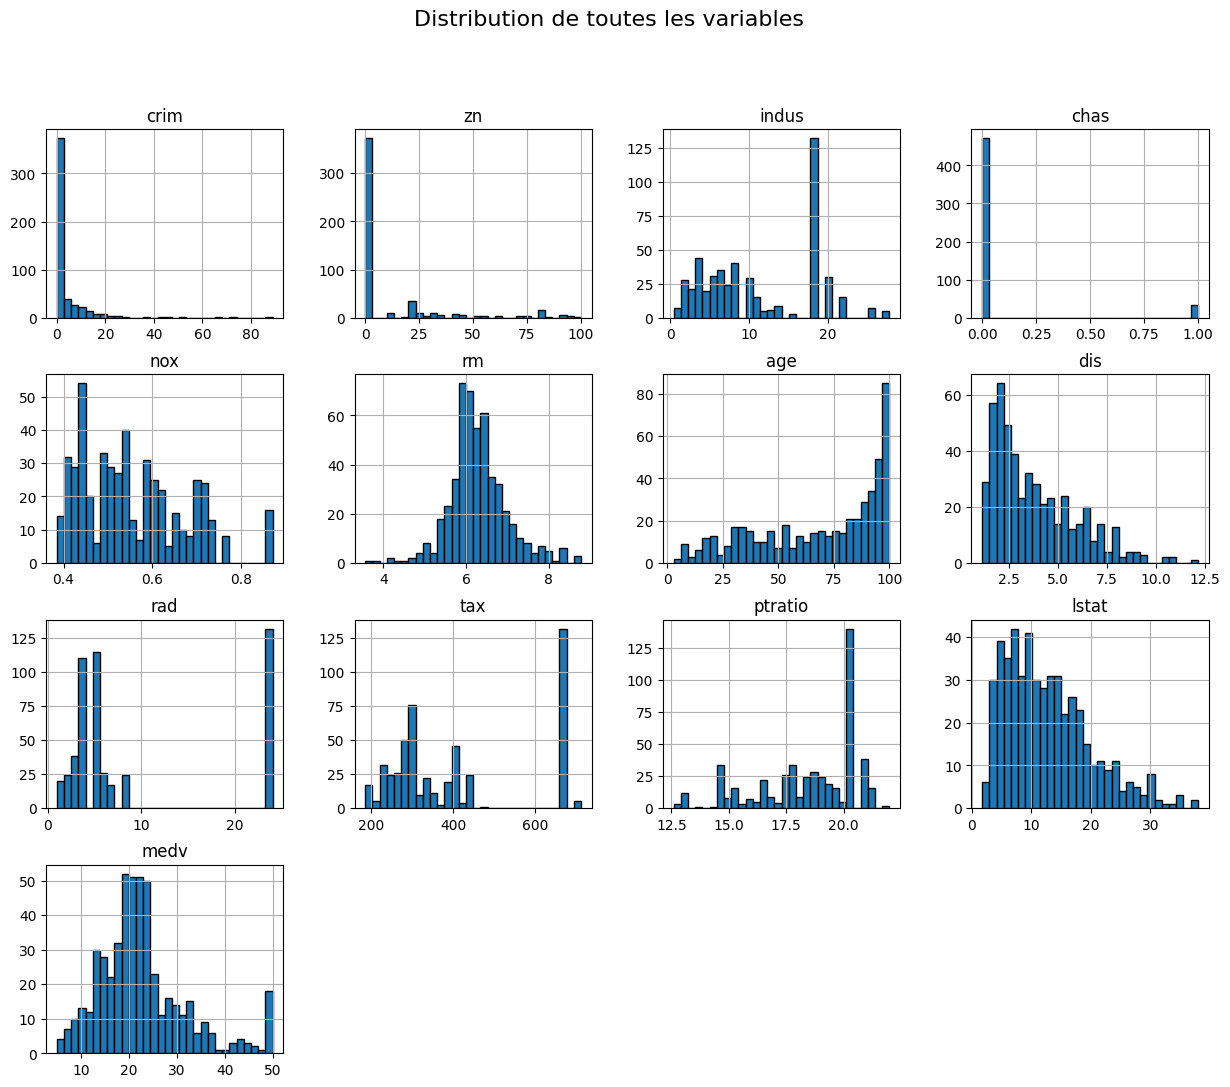

In [245]:
plt.figure(figsize=(15, 12))
analyse.hist(bins=30, figsize=(15, 12), edgecolor='black')
plt.suptitle("Distribution de toutes les variables", fontsize=16)
plt.show()

Au regard de la distribution on suspecte que :

- la variable **chas** est binaire et non continue, il faudra la recoder
- la variable **zn** possède énormément de valeurs à 0, quid de son pouvoir discriminant. Ne vaudrait-il pas mieux la recoder en binaire avec 2 catégories 0 vs autres ?
- De même pour la variable **crime** avec un taux de criminalité proche de 0 très important.


In [7]:
analyse

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,6.48,22.0


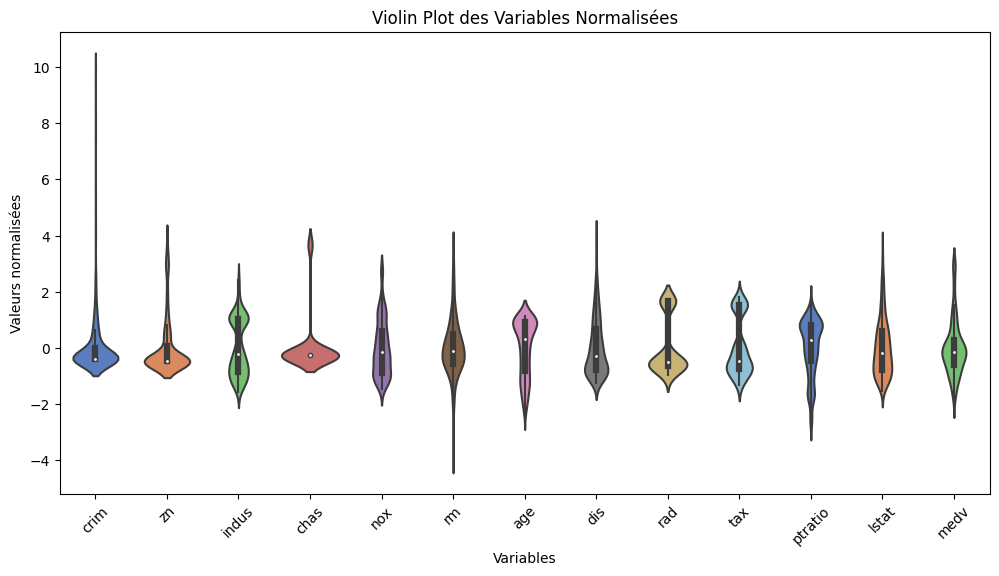

In [246]:
# Standardisation des données pour le boxplot

scaler_boxplot = StandardScaler()
df_scaled = pd.DataFrame(scaler_boxplot.fit_transform(analyse), columns=analyse.columns)

# Tracer un violon plot pour toutes les variables sur une seule figure
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_scaled, palette='muted')
plt.xticks(rotation=45)
plt.xlabel("Variables")
plt.ylabel("Valeurs normalisées")
plt.title("Violin Plot des Variables Normalisées")
plt.show()


Il semble que les variables **crim** & **rm** possèdent des queues de distributions dites Skew.  
L'intuition de passer crim en variable binaire peut être juste.

Notons également que la variable ***medv*** semble avoir une queue de distribution longue pour les valeurs élevées

#### Matrice des corrélations

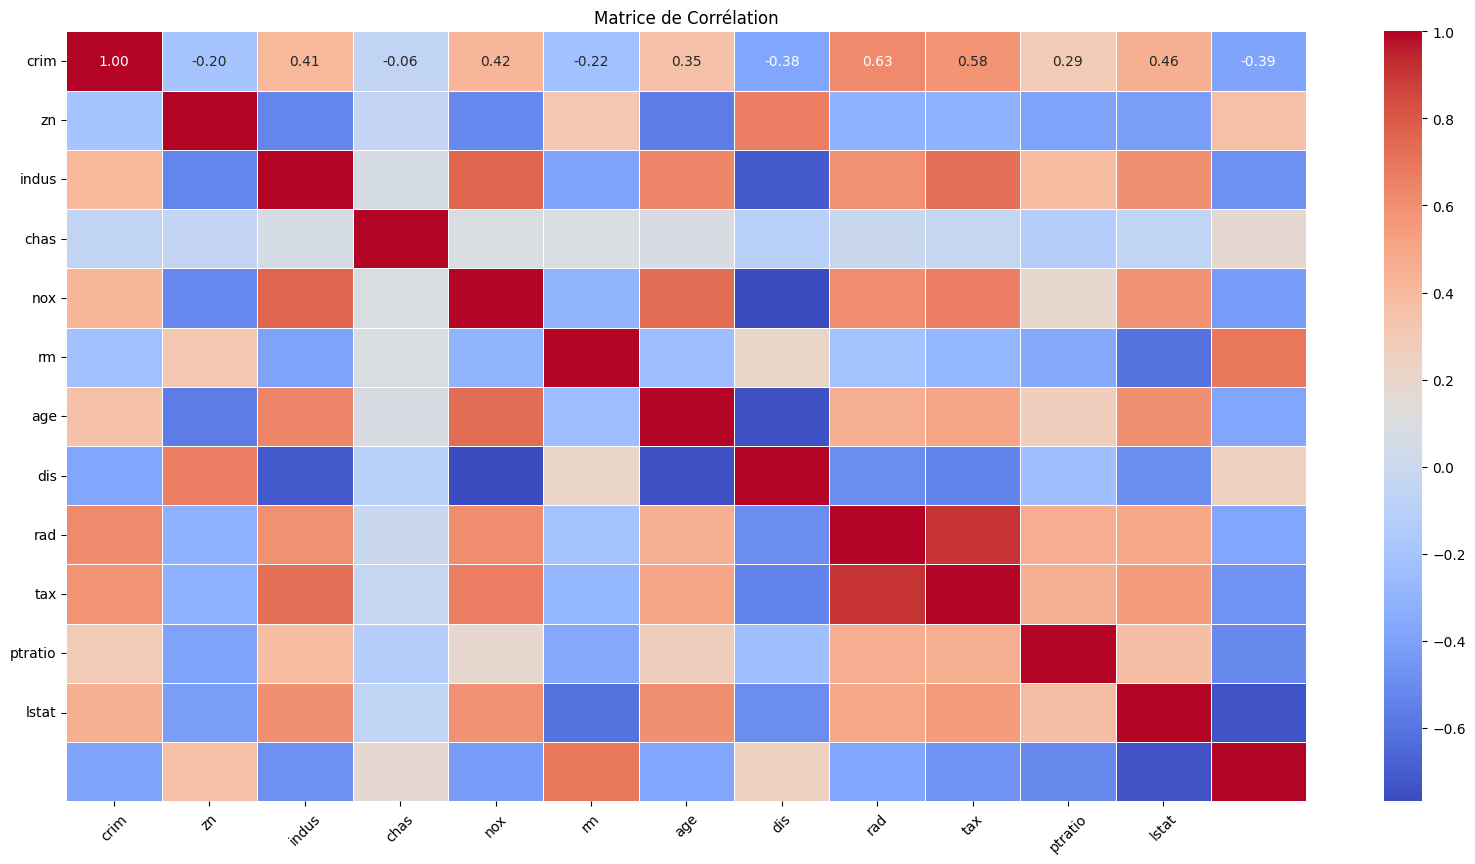

In [247]:
plt.figure(figsize=(20, 10))
corr_matrix = df_scaled.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, 
            xticklabels=features_name, yticklabels=features_name)

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Matrice de Corrélation")
plt.show()

In [248]:
# Filtrer les corrélations supérieures à 0.8 en valeur absolue
corr_filtered = corr_matrix.abs()
high_corr = corr_filtered[(corr_filtered > 0.7) & (corr_filtered < 1.0)].dropna(how='all').dropna(axis=1, how='all')

# Afficher le dataframe filtré
print(high_corr)


          indus       nox       age       dis       rad       tax     lstat  \
indus       NaN  0.763651       NaN  0.708027       NaN  0.720760       NaN   
nox    0.763651       NaN  0.731470  0.769230       NaN       NaN       NaN   
age         NaN  0.731470       NaN  0.747881       NaN       NaN       NaN   
dis    0.708027  0.769230  0.747881       NaN       NaN       NaN       NaN   
rad         NaN       NaN       NaN       NaN       NaN  0.910228       NaN   
tax    0.720760       NaN       NaN       NaN  0.910228       NaN       NaN   
lstat       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
medv        NaN       NaN       NaN       NaN       NaN       NaN  0.737663   

           medv  
indus       NaN  
nox         NaN  
age         NaN  
dis         NaN  
rad         NaN  
tax         NaN  
lstat  0.737663  
medv        NaN  


Après analyse des corrélations, on remarque que certaines variables sont fortement corrélées entre elles (supérieures à 0,9 ou à 0,75).

Il faut garder cela à l'esprit, car ces corrélations impacteront nos méthodes d'interprétation des modèles.

Idéalement, il serait pertinent de passer par une ACP ou de casser la corrélation en discrétisant certaines variables et/ou en appliquant des transformations pour briser le lien linéaire.

### Résumé

À ce stade, nous allons :

Transformer la variable crime en modalités afin de capturer l'information ville avec crime vs ville sans crime.

**dis** et **lstat**, étant très asymétriques, font l'objet d'une transformation logarithmique.

Appliquer une winsorisation afin de réduire l'asymétrie (skew) de nos variables.

In [324]:
# On recode la variable crim en binaire
analyse["is_criminal"] = pd.cut(analyse["crim"], bins=[0, 1, analyse.crim.max()], labels=[0,1])
#On recode la variable zn en binaire
analyse["is_zn"] = np.where(analyse["zn"] > 0, 1, 0)

#Transformation log sur les variables avec une queue de distribution importante
analyse['log_dis'] = np.log(analyse['dis'])
analyse['log_lstat'] = np.log(analyse['lstat'])

#On considère que chas est binaire
analyse.rename(columns={"chas": "is_chas"}, inplace=True)

# Variable à conserver pour la modélisation
features_model = analyse.drop(['crim','zn','medv'],axis=1).columns

In [325]:
X = analyse[features_model].copy()
y = analyse[target_name].copy()

In [326]:
#Train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)

In [327]:
#Winsorize outliers
for col in features_model:
    if not col.startswith('is_') : 
        print(f" winsorization de la variable : {col}") 
        X_train[col], X_test[col] = winsorize_data(xtrain= X_train, xtest= X_test, feature=col)

 winsorization de la variable : indus
 winsorization de la variable : nox
 winsorization de la variable : rm
 winsorization de la variable : age
 winsorization de la variable : dis
 winsorization de la variable : rad
 winsorization de la variable : tax
 winsorization de la variable : ptratio
 winsorization de la variable : lstat
 winsorization de la variable : log_dis
 winsorization de la variable : log_lstat


In [328]:
#Scaling features

scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

### 3)Créer 2 modèles baseline, linéaire et random forest

In [329]:
# Modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_sc, y_train)
y_pred_rf = rf_model.predict(X_test_sc)
rf_mse = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {rf_mse:.4f}")

# Modèle Régression Linéaire
lr_model = LinearRegression()
lr_model.fit(X_train_sc, y_train)
y_pred_lr = lr_model.predict(X_test_sc)
lr_mse = mean_squared_error(y_test, y_pred_lr)
print(f"Régression Linéaire MSE: {lr_mse:.4f}")

Random Forest MSE: 9.0732
Régression Linéaire MSE: 13.4202


### 4) Interpréter le modèle linéaire
Utiliser les méthodes intrinsèques du modèle pour l'interprétation

In [330]:
#coefficients standardisés
beta = pd.DataFrame(np.abs(lr_model.coef_),index=features_model,columns=['abs(coef)'])
beta.sort_values(by='abs(coef)', ascending=False)

,abs(coef)
log_lstat,7.078377
nox,2.138424
rm,1.939209
log_dis,1.817643
tax,1.799639
rad,1.786432
ptratio,1.486627
dis,1.482660
lstat,1.247978
is_chas,0.688467


La valeur absolue de nos coefficients, qui ont été standardisés auparavant, nous permet de connaître l'importance de chaque variable dans notre modèle linéaire.

Le top 3 des variables ayant le plus d'importance :

**log_lstat** : Log du nombre de personnes avec un revenu bas.

**nox** : La concentration en particules d'azote.

**rm** : Le nombre de pièces moyen par logement.

Les variables **indus** et **is_zn** ne semblent pas participer au modèle.

On examine maintenant les effets relatifs 

In [152]:
# Coéfficients avec les signes ordre des liaisons variables target
beta = pd.DataFrame(lr_model.coef_,index=features_model,columns=['coef'])
beta.sort_values(by='coef', ascending=False)

,coef
rm,1.939209
rad,1.786432
lstat,1.247978
is_chas,0.688467
age,0.628986
is_zn,0.336817
indus,0.014027
is_criminal,-0.425319
dis,-1.482660
ptratio,-1.486627


Examinons maintenant les effets relatifs.

**RM** : Plus le nombre de pièces moyen augmente, plus la valeur moyenne des biens augmente.

**nox** : Plus la concentration en particules augmente, plus la valeur moyenne des biens diminue.

**log_lstat** : Plus la valeur du log de la population à bas revenus augmente, plus la valeur moyenne des biens diminue.

### 5) Tuner votre random forest

In [153]:
param_dist = {
    'n_estimators': [100, 200, 500],  # Plus d'arbres
    'max_depth': [5, 10, 20, 30, 40],  # Profondeur maximale
    'min_samples_split': [2, 5, 10,15],  # Taille min de split
    'min_samples_leaf': [2,4,6,8],  # Taille min des feuilles
    'max_features' : ['sqrt'],
    'criterion': ['squared_error',"absolute_error"]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Teste 30 configurations
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1   ,
    verbose=2,
    random_state=42
)

In [154]:
random_search.fit(X_train_sc, y_train)
print("Meilleurs paramètres (RandomizedSearch) :", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleurs paramètres (RandomizedSearch) : {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'criterion': 'absolute_error'}


In [155]:
# Trier les résultats du meilleur au pire
# Récupérer tous les résultats
results_df = pd.DataFrame(random_search.cv_results_)
results_df = results_df.sort_values(by="rank_test_score")

# Afficher les meilleurs essais
results_df[['rank_test_score','mean_test_score', 'std_test_score', 'params']].head(10)


,rank_test_score,mean_test_score,std_test_score,params
12,1,-13.715965,2.393132,"{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'criterion': 'absolute_error'}"
24,2,-14.534663,2.553789,"{'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'squared_error'}"
30,3,-14.640754,2.433042,"{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'absolute_error'}"
16,4,-14.766891,2.734247,"{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'squared_error'}"
28,5,-15.261320,2.686627,"{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'absolute_error'}"
36,6,-15.331433,2.554323,"{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'absolute_error'}"
4,7,-15.394947,2.682349,"{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'absolute_error'}"
29,8,-15.418605,3.475513,"{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'squared_error'}"
13,9,-15.523687,2.110560,"{'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'absolute_error'}"
49,10,-15.583208,3.172148,"{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'squared_error'}"


Il me semble que notre jeu de données n'est pas très complexe, car 200 arbres suffisent pour réaliser la meilleure prédiction.
En revanche, une profondeur de 40 splits est étonnante et doit sûrement produire un modèle qui surapprend.

Il convient de vérifier la différence avec un jeu de test pour voir si ce meilleur modèle est généralisable.

Cela ne sera pas fait ici, mais il serait également intéressant de regarder les courbes de validation des n_estimators afin de voir leur impact sur la qualité de la prédiction. Augmenter le nombre d'arbres au-delà de 200 est-il utile, toutes choses égales par ailleurs.

#### Comparer train & test

In [331]:
# Modèle Random Forest
best_model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=40,criterion="absolute_error", max_features='sqrt', min_samples_split=2, min_samples_leaf=2)
best_model.fit(X_train_sc, y_train)

y_pred_rf_test = best_model.predict(X_test_sc)
y_pred_rf_train = best_model.predict(X_train_sc)

rf_mse_test = mean_squared_error(y_test, y_pred_rf_test)
rf_mse_train = mean_squared_error(y_train, y_pred_rf_train)

print(f"Random Forest MSE TRAIN: {rf_mse_train:.4f}")
print(f"Random Forest MSE TEST: {rf_mse_test:.4f}")


Random Forest MSE TRAIN: 4.9705
Random Forest MSE TEST: 6.8973


2 points d'écart. Nous sommes en présence de sur-apprentissage. 

Lorsqu'on utilise des modèles basés sur des abres on peut jouer sur les hyperparamètres suivants afin de réduire l'overfitting :
  
- **max_depth** (Profondeur maximale) :

Limite la profondeur des arbres. Une profondeur trop élevée entraîne un apprentissage excessif des données d'entraînement.

✅ Solution : Fixer une profondeur raisonnable, par exemple entre 5 et 20, en fonction de la complexité des données.

**min_samples_split** (Nombre minimum d'échantillons pour diviser un nœud) :

Définit le nombre minimum d'échantillons nécessaires pour diviser un nœud.

✅ Solution : Augmenter la valeur par défaut (2). Tester des valeurs comme 5, 10, 20.

**min_samples_leaf** (Nombre minimum d'échantillons dans une feuille) :

Évite d'avoir des feuilles contenant un nombre trop faible d'échantillons, ce qui peut rendre le modèle trop spécifique.

✅ Solution : Augmenter cette valeur (ex. 5, 10, 20).

**n_estimators** (Nombre d'arbres) :

Paradoxalement, un trop grand nombre d'arbres peut renforcer le sur-apprentissage, même si souvent ça aide à la généralisation.

✅ Solution : Tester des valeurs de 100 à 500 arbres en fonction des performances.


Itération succeessive sur ce gridsearch afin de trouver la meilleur combinaisons d'hyperparamètre minisant l'erreur et permettant de généraliser à X_test

In [158]:
param_dist = {
    'n_estimators': [70,72,74,76,78,80],  # Plus d'arbres
    'max_depth': [15,16,17,18],  # Profondeur maximale
    'min_samples_split': [3,4],  # Taille min de split
    'min_samples_leaf': [3,4],  # Taille min des feuilles
    'max_features' : ['sqrt'],
    'criterion': ['squared_error']
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_dist,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

In [159]:
grid_search.fit(X_train_sc, y_train)
print("Meilleurs paramètres (GridSearch) :", grid_search.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Meilleurs paramètres (GridSearch) : {'criterion': 'squared_error', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 78}


In [160]:
# Trier les résultats du meilleur au pire

# Récupérer tous les résultats
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by="rank_test_score")

# Afficher les meilleurs essais
results_df[['rank_test_score','mean_test_score', 'std_test_score', 'params']].head(10)


,rank_test_score,mean_test_score,std_test_score,params
34,1,-14.828953,3.481024,"{'criterion': 'squared_error', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 78}"
28,1,-14.828953,3.481024,"{'criterion': 'squared_error', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 78}"
4,3,-14.830414,3.479631,"{'criterion': 'squared_error', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 78}"
10,3,-14.830414,3.479631,"{'criterion': 'squared_error', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 78}"
58,5,-14.832580,3.477568,"{'criterion': 'squared_error', 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 78}"
52,5,-14.832580,3.477568,"{'criterion': 'squared_error', 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 78}"
76,5,-14.832580,3.477568,"{'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 78}"
82,5,-14.832580,3.477568,"{'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 78}"
35,9,-14.888272,3.545857,"{'criterion': 'squared_error', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 80}"
29,9,-14.888272,3.545857,"{'criterion': 'squared_error', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 80}"


In [332]:
# Modèle Random Forest
best_model = RandomForestRegressor(n_estimators=70, random_state=42, max_depth=15, min_samples_split=3, min_samples_leaf=3,max_features='sqrt', criterion="squared_error")
best_model.fit(X_train_sc, y_train)

y_pred_rf_test = best_model.predict(X_test_sc)
y_pred_rf_train = best_model.predict(X_train_sc)

rf_mse_test = mean_squared_error(y_test, y_pred_rf_test)
rf_mse_train = mean_squared_error(y_train, y_pred_rf_train)

print(f"Random Forest MSE TRAIN: {rf_mse_train:.4f}")
print(f"Random Forest MSE TEST: {rf_mse_test:.4f}")


Random Forest MSE TRAIN: 6.4521
Random Forest MSE TEST: 6.9963


On conserve comme meilleur paramètre : 
- N_estimator =70
- max_depth = 15 
- min_samples_split=3
- min_samples_leaf=3
- max_features="sqrt"

In [257]:
i=50
predic_medv = best_model.predict(X_test_sc[i].reshape(1, -1))
real_medv = y_test.reset_index().iloc[i,1]

print(f"""On prédit pour le {i} ème bien la valeur de {predic_medv} alors que le montant moyen était de {real_medv}
      """)


On prédit pour le 50 ème bien la valeur de [20.04703942] alors que le montant moyen était de 18.9
      


##### On trace la qualité de prédiction de notre modèle

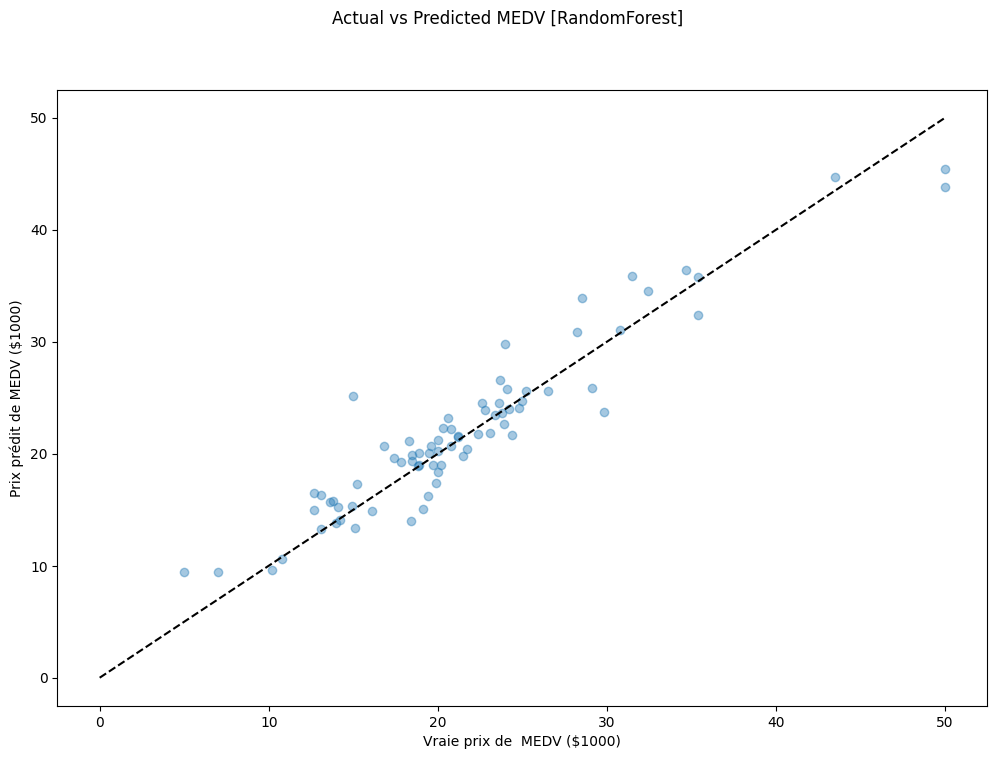

In [258]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Actual vs Predicted MEDV [RandomForest]')
plt.scatter(y_test, y_pred_rf_test, alpha=0.4)
plt.plot([0, 50], [0, 50], '--k')
 
plt.xlabel('Vraie prix de  MEDV ($1000)')
plt.ylabel('Prix prédit de MEDV ($1000)')
 
plt.show()

Au regard de l'écart entre les valeurs réelles et prédites, notre modèle semble bien inférer de nouvelles données.

De plus, il semble s'adapter à des biens à faible et à forte valeur.

### 6) Interpréter globalement votre modèle meilleur modèle RF 
   1) Utiliser les PDP ou ALE & Permutation feature Importance 
   2) Comparer les résulats du random forest avec votre interprétation du modèle linéaire

In [259]:
feature_importance_df = pd.DataFrame({'Feature': features_model, 'Importance': best_model.feature_importances_})

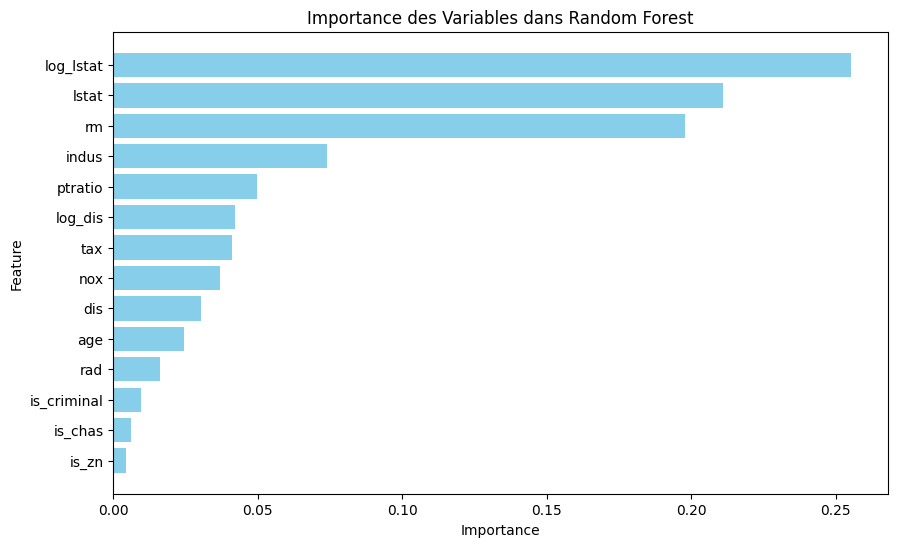

In [333]:
# Plot de l'importance des features

order_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(order_importance['Feature'], order_importance['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Importance des Variables dans Random Forest")
plt.gca().invert_yaxis()  # Inverser pour que la plus importante soit en haut
plt.show()

Les variables participant le plus à notre modèle sont **lstat**, **log_lstat**, **rm** et **indus**.

À l'inverse du modèle linéaire, cette fois indus participe activement au modèle.

In [261]:
df_interpret = pd.DataFrame(X_test_sc, columns = features_model)

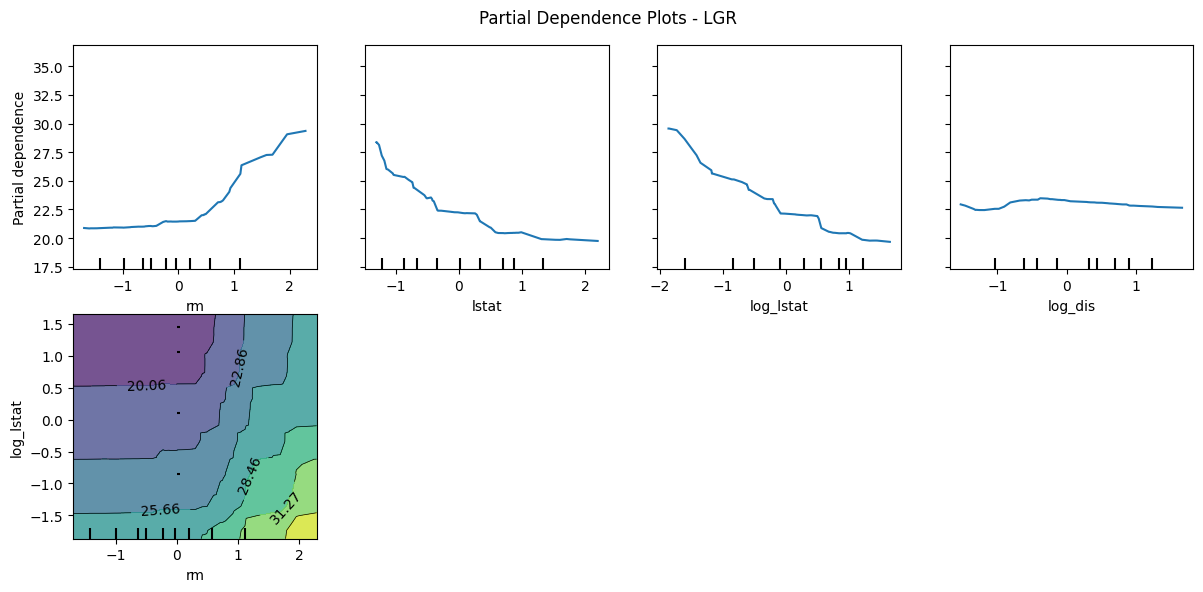

In [262]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["rm","lstat","log_lstat",'log_dis' ,('rm','log_lstat')]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(best_model,  #votre modèle
                                         df_interpret, 
                                         features,
                                         kind="average",
                                         ax = ax1,
                                         grid_resolution=100, # Nombre de points estimés pour le tracer de la courbe
                                         n_cols=4
                                         )
plt.suptitle("Partial Dependence Plots - LGR")
plt.tight_layout()
plt.show()

Plus on augmente la valeur de RM du nombre de pièce par logement plus la valeur du logement augmnente. Jusque ici de pas de surprise.

Cependant on voit que l'impact sur MEDV n'est pas linéaire et qu'il augmente de façon beaucoup plus importante quand s'écarte de plus d'une '
fois de son écart type.

Il est ici intéressant de se ramener aux valeurs d'origines afin de mieux comprendre

()

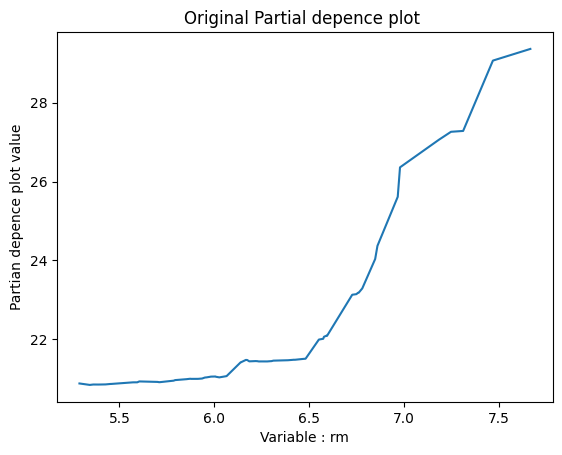

In [263]:
display_original_pdp_values(3, best_model, df_interpret, scaler)

Au-delà de 6,5 pièces, les effets semblent très importants sur le prix moyen des biens.

Attention, on affiche ici les données winsorisées et non les données originales.

In [264]:
result = permutation_importance(best_model, X_test_sc, y_test,
                           n_repeats=15,
                           random_state=0,
                           scoring="neg_mean_squared_error"
                           )


### Comparaison entre random forest variable importance et variable importance agnostic 

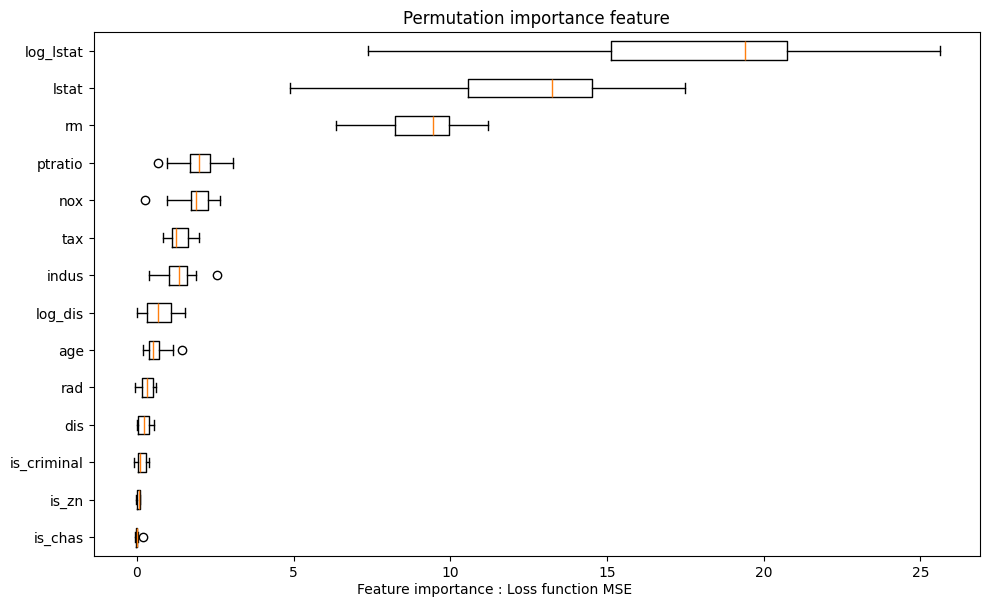

In [265]:
perm_sorted_idx = result.importances_mean.argsort()

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
ax1.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=features_model[perm_sorted_idx]
)
plt.title('Permutation importance feature')
fig.text(.5, .001, "Feature importance : Loss function MSE", ha='center')

fig.tight_layout()
plt.show()

On retrouve des résultats similaires avec les variables importantes du random forest.

Si nous permutons les valeurs de la variable **log_lstat**, cela aura pour effet d'augmenter le MSE de 18 en moyenne.

#### Regardons maintenant si nos variables ont des effets joints

In [266]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(best_model, pd.DataFrame(X_test_sc, columns=features_model))

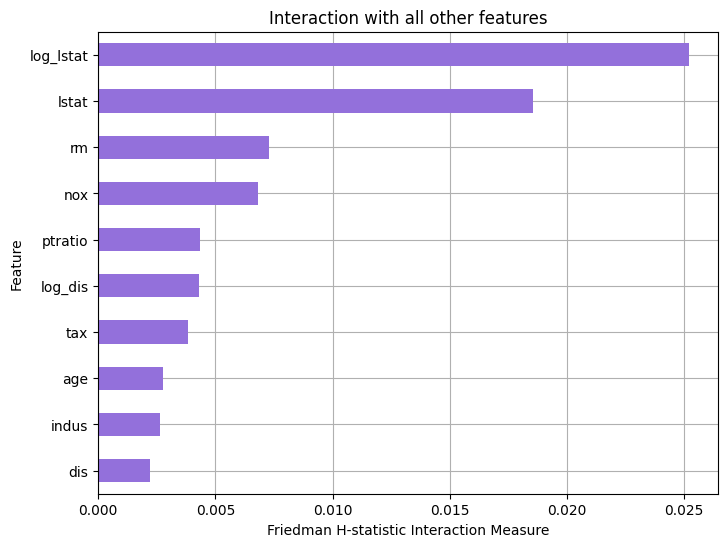

In [267]:
# Interaction One vs All
h_stat.plot(vis_type="bar_chart_ova",top_k=10 )
 

Il n'y a pas d'effet join statistiquement signifiatif <2.5%

### 7) Réaliser une explicabilité par individu sur le modèle RF
- 1) ICE, le PDP est-il une bonne représentation des variables importantes de votre modèle?
- 2) LIME
- 3) SHAP watterfall plot

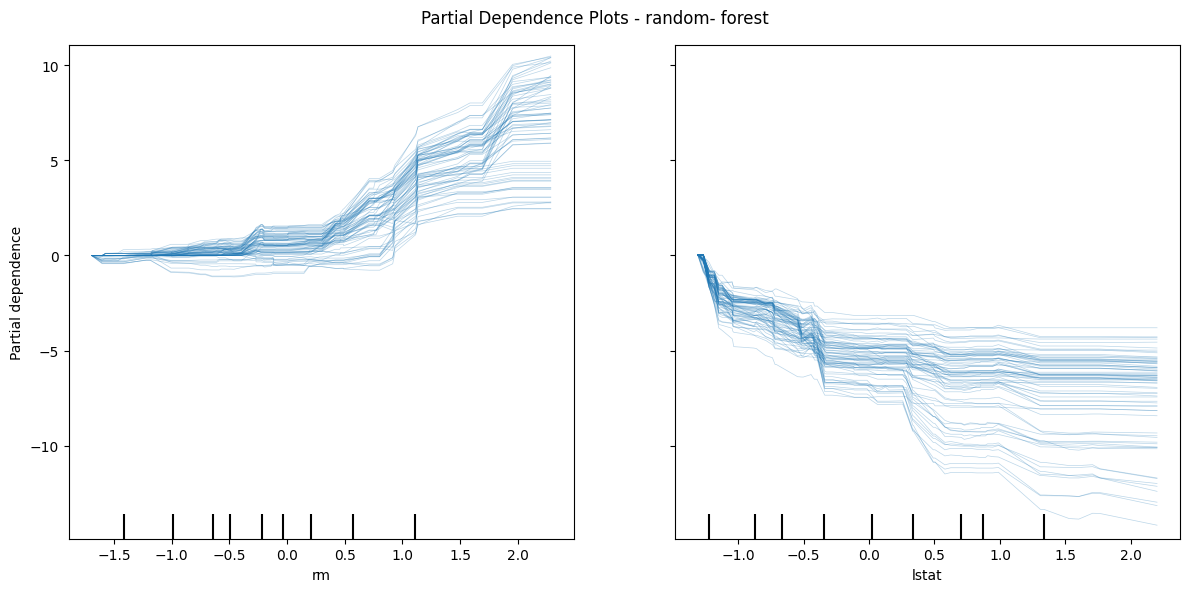

In [268]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["rm","lstat"]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(best_model,  #votre modèle
                                         df_interpret, 
                                         features,
                                         kind="individual",
                                         ax = ax1,
                                         n_cols=3,
                                         centered=True
                                         )
plt.suptitle("Partial Dependence Plots - random- forest")
plt.tight_layout()
plt.show()

Il ne semble pas y avoir d'hétérogénéité dans les individus. Si on regarde la variable **rm**, les PDP semblent être une bonne représentation.

En revanche, la lecture est légèrement différente pour lstat, où l'effet de plateau après 0,5 écart-type ne semble pas s'appliquer à tous les individus.

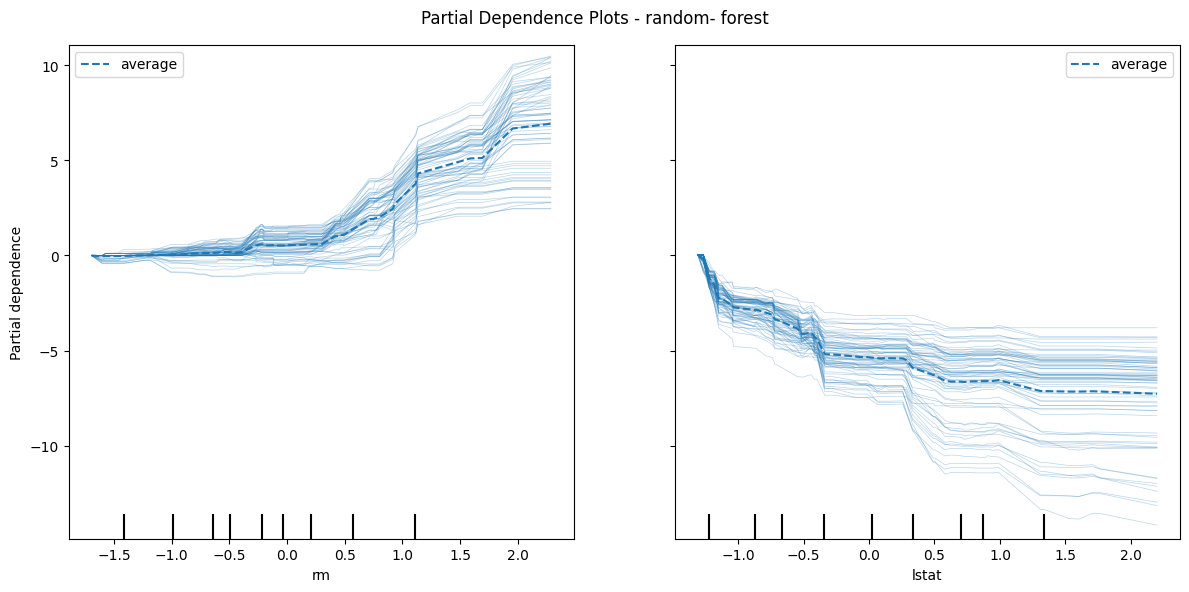

In [269]:
# PDP pour plusieurs caractéristiques (par exemple, 'sepal length' et 'petal width')
features = ["rm","lstat"]  # Index des caractéristiques
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(best_model,  #votre modèle
                                         df_interpret, 
                                         features,
                                         kind="both",
                                         ax = ax1,
                                         n_cols=3,
                                         centered=True,
                                         contour_kw={'alpha': 0.1}
                                         )
plt.suptitle("Partial Dependence Plots - random- forest")
plt.tight_layout()
plt.show()

#### Lime explanation

In [292]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_sc, 
                                                   feature_names=features_model ,
                                                   class_names=['medv']  ,
                                                   verbose=True,
                                                     mode='regression'
                                                     )

In [293]:
i = 50
exp = explainer.explain_instance(X_test_sc[i], best_model.predict)

Intercept 24.94923063459735
Prediction_local [20.35416712]
Right: 20.04703942486085


In [294]:
exp.show_in_notebook(show_table=True, show_all=False)

Si on utilise l'algorithme Lime pour comprendre comment notre prédiction se réalise pour le 50ᵉ individu, on remarque :

- Que **log_lstat**, rm et lstat vont avoir tendance à diminuer le prix du bien. Cela est cohérent avec la compréhension globale que nous avons du modèle. **log_lstat** a pour valeur 0,38, ce qui signifie que cet individu possède une plus grande proportion de population à bas revenus comparativement aux autres, et rm à -0,49 indique qu'il y a moins de pièces en moyenne.

- **Ptratio** fait augmenter la valeur moyenne des biens, car celui-ci est négatif. Un ratio élève-enseignant plus faible signifie qu'il y a plus d'enseignants en moyenne, ce qui peut traduire une meilleure qualité d'enseignement.

#### Shapley value

In [ ]:
#Init shapley values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(df_interpret)

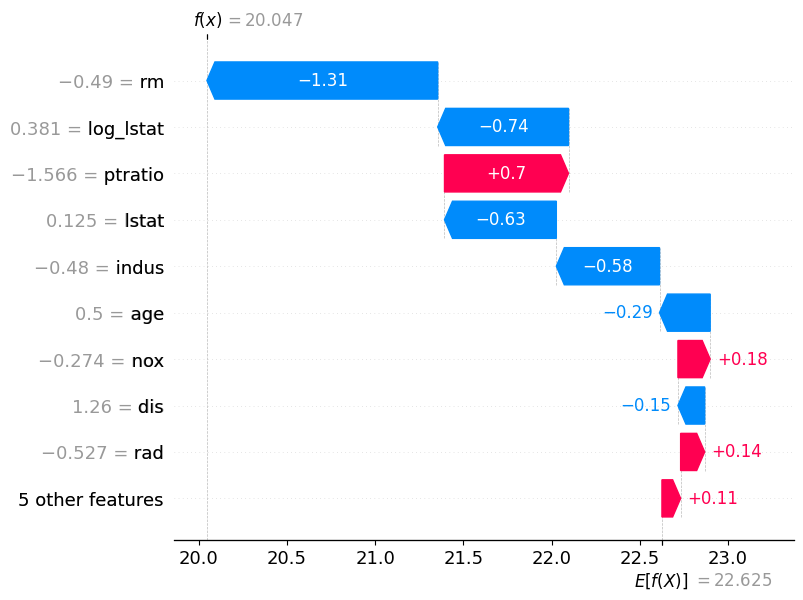

In [299]:
shap.initjs()
# visualize the first prediction's explanation
shap.waterfall_plot(shap_values[50])

A la lecture du graphique waterfall_plot on peut observer :

La valeur moyenne de MEDV (E[f(x)] = 22,625) 

La valeur prédite par notre modèle pour le 50ème individu (f(x) = 20,047)  


**Variables négatives (en bleu) : Elles réduisent la valeur prédite du prix de l'immobilier.**

rm (-1.31) : Moins de pièces (rm) réduit fortement le prix du bien. Cela est logique, car un logement avec peu de pièces est généralement moins cher.

log_lstat (-0.74) : Une proportion élevée de population à bas revenus a tendance à diminuer le prix du bien. (Attention à l'interprétation, nos 2 variables sont peut être liées)

lstat (-0.63) : Confirme l'effet négatif d'une population à bas revenus.

indus (-0.58) : Le manque d'activités commerciales diminue le prix des biens (Plus de place à d'autres activités? Manque de magasin ? )

**Variables positives (en rouge) : Elles augmentent la valeur prédite du prix de l'immobilier.**

ptratio (+0.7) : Ptratio fait augmenter la valeur moyenne des biens, car celui-ci est négatif. Un ratio élève-enseignant plus faible signifie qu'il y a plus d'enseignants en moyenne, ce qui peut traduire une meilleure qualité d'enseignement.

### 8) Explorer les graphiques SHAP étudiés  dans la partie CM
   1) beeswarm (Contribution des variables)
   2) scatter (équivalent pdp)

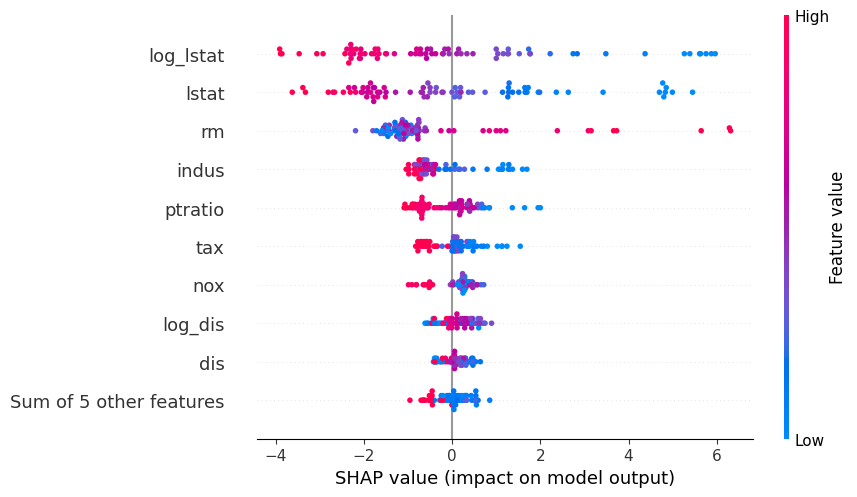

In [232]:
shap.plots.beeswarm(shap_values)

En rouge on peut observer les valeurs élévées des features et en bleu les valeurs plus faibles.

Pourquoi les variables qui influencent le plus notre modèle il ne semble pas y avoir de comportement hétérogène.

Les valeurs élévées de log_lstat ont tendance à dimuner la valeur des biens.
Remarque, il pourrait être intéresant de passer en log la variable **rm** au vu de sa distribution.

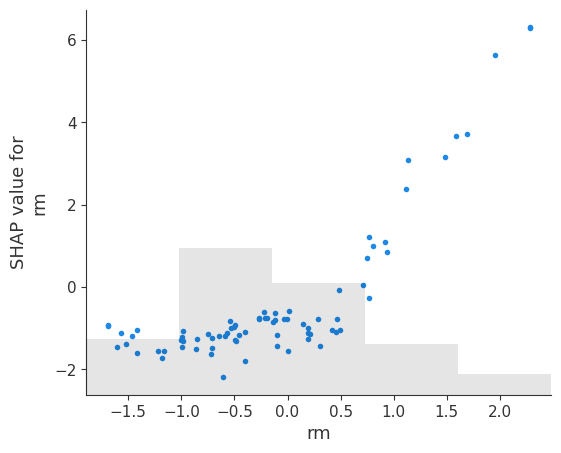

In [300]:
shap.plots.scatter(shap_values[:, 'rm'])

L'effet individuel de chaque individu pour la valeur de shapley avec un scatter plot se comporte comme la Partial Depence Plot tracer plus haut.
C'est un bon indicateur pour une compréhension générale et non locale.